<h1> Engineer Holidayness Feature </h1>

In this notebook, we aim to develop a single **holidayness feature** from the holiday and school-free flags in the DataFrame`DE_hol_df` with a high predictivity for the grid load. For this we apply two paramter-dependend mathematical operations:

- A convex combination of the holiday and school-free flags.
- A "smoothing" of the resulting combined values.  

The second operation reflects observations from OPSD_EDA.ipynb that weekends tend to reduce grid load on adjacent workdays. We assume at this point, that holidayness also accumulates during long holiday or school-free perdiods, like Easter, Christmas, or the summer holidays.  
Since holidays and school periods are subject to state law in Germany, we will work with the **TransnetBW** grid load data and the holiday data for the state of **Baden-Württemberg** to optimize our holidayness feature. This is for the simple reason that this is the only matching pair of load and holiday data available to us.  

In [35]:
from pathlib import Path
import sys
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config as cfg
from src import eda_utils
from src import plotting_utils
from src import config as cfg
from src import filter_group_aggr_utils as fga
from src import feature_anal_eng as fae 

from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import math


<h2> Build the Baden-Württemberg DataFrame </h2>

We load the DataFrames from the `../data/processed` Folder 

In [36]:
DATA_PROCESSED = Path("../data/processed")

# --- Load Parquet files ---
OPSD_60min_DE_LU_df = pd.read_parquet(DATA_PROCESSED / "OPSD_60min_de_lu_df.parquet")
DE_hol_df  = pd.read_parquet(DATA_PROCESSED / "DE_hol_df.parquet")

# --- Quick check ---
print("Loaded DataFrames:")
print(f"OPSD_60min_DE_LU_df.shape: {OPSD_60min_DE_LU_df.shape}")
print(f"DE_hol_df.shape: {DE_hol_df.shape}")


Loaded DataFrames:
OPSD_60min_DE_LU_df.shape: (50401, 45)
DE_hol_df.shape: (7670, 37)


We make copies of the DataFrames, with features relevant to **Baden-Württemberg**  only. 

In [37]:
DE_BW_hol_df = DE_hol_df[[ "local_date", "local_start", "local_end",	"utc_start",	"utc_end",	"DE_BW_school_free",	"DE_BW_hol"]].copy()
DE_BW_hol_df.head(5)

,local_date,local_start,local_end,utc_start,utc_end,DE_BW_school_free,DE_BW_hol
0,2015-01-01,2015-01-01 00:00:00+01:00,2015-01-02 00:00:00+01:00,2014-12-31 23:00:00+00:00,2015-01-01 23:00:00+00:00,1,1
1,2015-01-02,2015-01-02 00:00:00+01:00,2015-01-03 00:00:00+01:00,2015-01-01 23:00:00+00:00,2015-01-02 23:00:00+00:00,1,0
2,2015-01-03,2015-01-03 00:00:00+01:00,2015-01-04 00:00:00+01:00,2015-01-02 23:00:00+00:00,2015-01-03 23:00:00+00:00,1,0
3,2015-01-04,2015-01-04 00:00:00+01:00,2015-01-05 00:00:00+01:00,2015-01-03 23:00:00+00:00,2015-01-04 23:00:00+00:00,1,0
4,2015-01-05,2015-01-05 00:00:00+01:00,2015-01-06 00:00:00+01:00,2015-01-04 23:00:00+00:00,2015-01-05 23:00:00+00:00,1,0


In [38]:
BW_cols = [col for col in OPSD_60min_DE_LU_df.columns if ("transnetbw" in col) or  ("timestamp" in col)]
print(BW_cols)

['utc_timestamp', 'cet_cest_timestamp', 'DE_transnetbw_load_actual_entsoe_transparency', 'DE_transnetbw_load_forecast_entsoe_transparency', 'DE_transnetbw_solar_generation_actual', 'DE_transnetbw_wind_onshore_generation_actual']


In [39]:
OPSD_60min_BW_df =  OPSD_60min_DE_LU_df[BW_cols].copy()
print(OPSD_60min_BW_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 6 columns):
 #   Column                                           Non-Null Count  Dtype                        
---  ------                                           --------------  -----                        
 0   utc_timestamp                                    50401 non-null  datetime64[ns, UTC]          
 1   cet_cest_timestamp                               50401 non-null  datetime64[ns, Europe/Berlin]
 2   DE_transnetbw_load_actual_entsoe_transparency    50400 non-null  float64                      
 3   DE_transnetbw_load_forecast_entsoe_transparency  50376 non-null  float64                      
 4   DE_transnetbw_solar_generation_actual            50386 non-null  float64                      
 5   DE_transnetbw_wind_onshore_generation_actual     50400 non-null  float64                      
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1), float64(4)
memory usage: 2

We initialize the holiday and school-free columns of `OPSD_60min_BW_df`.

In [40]:
OPSD_60min_BW_df["DE_BW_hol"] = np.uint8(0)
OPSD_60min_BW_df["DE_BW_school_free"] = np.uint8(0)

We iterate over each `utc_timestamp` in `OPSD_60min_BW_df` and, for each hour, look up the corresponding holiday and school-free flags in `DE_BW_hol_df`, then assign these values to the matching row in `OPSD_60min_BW_df`.
 

In [41]:
for idx, utc_ts in OPSD_60min_BW_df["utc_timestamp"].items():  
    row = DE_BW_hol_df.loc[
        (DE_BW_hol_df["utc_start"] < utc_ts) &
        (utc_ts <= DE_BW_hol_df["utc_end"]),
        ["DE_BW_hol", "DE_BW_school_free"]
    ]
    if not row.empty:
        OPSD_60min_BW_df.at[idx, "DE_BW_hol"] = np.uint8(row["DE_BW_hol"].iloc[0])
        OPSD_60min_BW_df.at[idx, "DE_BW_school_free"] = np.uint8(row["DE_BW_school_free"].iloc[0])


print("Flags assigned by timestamp iteration.")
print(OPSD_60min_BW_df[["utc_timestamp", "DE_BW_hol", "DE_BW_school_free"]].head())


Flags assigned by timestamp iteration.
              utc_timestamp  DE_BW_hol  DE_BW_school_free
0 2014-12-31 23:00:00+00:00          0                  0
1 2015-01-01 00:00:00+00:00          1                  1
2 2015-01-01 01:00:00+00:00          1                  1
3 2015-01-01 02:00:00+00:00          1                  1
4 2015-01-01 03:00:00+00:00          1                  1


In [42]:
BW_load_hol_df = OPSD_60min_BW_df[["utc_timestamp","cet_cest_timestamp","DE_transnetbw_load_actual_entsoe_transparency", "DE_BW_hol",	"DE_BW_school_free"]]
BW_load_hol_df.head(5)

,utc_timestamp,cet_cest_timestamp,DE_transnetbw_load_actual_entsoe_transparency,DE_BW_hol,DE_BW_school_free
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,0,0
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,5307.0,1,1
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,5087.0,1,1
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,4906.0,1,1
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,4865.0,1,1


<h2> Hourly Profile depending on Holiday Status</h2>

OPSD follows end of the hour convention, the timestamps represent the hours ending at the timestamp's time. Therefore, we must make sure, that 00:00 timestamps are grouped to the day ending at that time. For this, we subtract a nanosecond. 

In [43]:
mon_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(0,))  # Mon
tue_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(1,))  # Tue
wed_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(2,))  # Wed
thu_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(3,))  # Thu
fri_mask   = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(4,))    # Fri
sat_mask   = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(5,))    # Sat
sun_mask   = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(6,))    # Sun

In [44]:
BW_hol_mask = BW_load_hol_df["DE_BW_hol"]==1
BW_school_free_mask = BW_load_hol_df["DE_BW_school_free"]==1
BW_school_day_mask = BW_load_hol_df["DE_BW_school_free"]==0

In [45]:
BW_load_hol_df[fri_mask ].head(5)

,utc_timestamp,cet_cest_timestamp,DE_transnetbw_load_actual_entsoe_transparency,DE_BW_hol,DE_BW_school_free
25,2015-01-02 00:00:00+00:00,2015-01-02 01:00:00+01:00,4990.0,0,1
26,2015-01-02 01:00:00+00:00,2015-01-02 02:00:00+01:00,4860.0,0,1
27,2015-01-02 02:00:00+00:00,2015-01-02 03:00:00+01:00,4761.0,0,1
28,2015-01-02 03:00:00+00:00,2015-01-02 04:00:00+01:00,4913.0,0,1
29,2015-01-02 04:00:00+00:00,2015-01-02 05:00:00+01:00,5055.0,0,1


First, we build profiles for all weekdays **without restrictions** to any holiday type.

In [46]:
BW_mon_prof, BW_mon_meta = fga.aggregate_hourly_profile(BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", 
                                                                "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=mon_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_tue_prof, BW_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=tue_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_wed_prof, BW_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= wed_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_thu_prof, BW_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= thu_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_fri_prof, BW_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= fri_mask , drop_dst_switch_dates=True, return_counts=True
)
BW_sat_prof, BW_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= sat_mask , drop_dst_switch_dates=True, return_counts=True
)
BW_sun_prof, BW_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask= sun_mask , drop_dst_switch_dates=True, return_counts=True
)


We build the **holiday profiles**.

In [47]:
BW_hol_mon_prof, BW_hol_mon_meta = fga.aggregate_hourly_profile(BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", 
                                                                "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_tue_prof, BW_hol_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_wed_prof, BW_hol_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_thu_prof, BW_hol_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_fri_prof, BW_hol_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_sat_prof, BW_hol_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_sun_prof, BW_hol_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)


Next, the school-free profiles. 

In [48]:
BW_school_free_mon_prof, BW_school_free_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_tue_prof, BW_school_free_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_wed_prof, BW_school_free_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_thu_prof, BW_school_free_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_fri_prof, BW_school_free_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_sat_prof, BW_school_free_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_sun_prof, BW_school_free_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)


We also restrict to non-school-free days. That is: School days.

In [49]:
BW_school_day_mon_prof, BW_school_day_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_tue_prof, BW_school_day_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_wed_prof, BW_school_day_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_thu_prof, BW_school_day_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_fri_prof, BW_school_day_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)



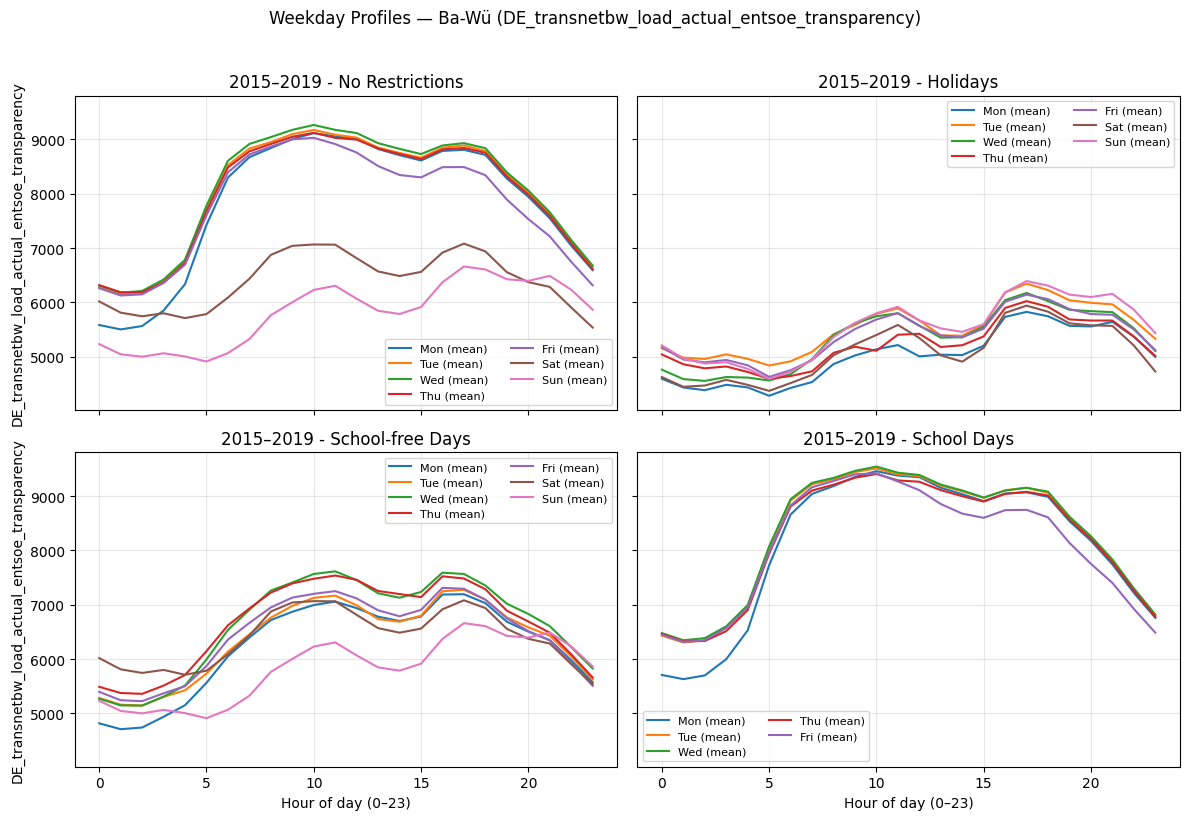

In [50]:
def _plot_weekday_set(ax, profiles, title, ylabel=None, xlabel=False):
    # profiles: list of (label, df_with_columns_hour_value)
    for label, prof in profiles:
        ax.plot(prof["hour"], prof["value"], label=label)
    if xlabel:
        ax.set_xlabel("Hour of day (0–23)")
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(ncols=2, fontsize=8)
# --- Assemble profile lists ---


profiles_no_restr = [
    ("Mon (mean)", BW_mon_prof),
    ("Tue (mean)", BW_tue_prof),
    ("Wed (mean)", BW_wed_prof),
    ("Thu (mean)", BW_thu_prof),
    ("Fri (mean)", BW_fri_prof),
    ("Sat (mean)", BW_sat_prof),
    ("Sun (mean)", BW_sun_prof),
]


profiles_BW_hol = [
    ("Mon (mean)", BW_hol_mon_prof),
    ("Tue (mean)", BW_hol_tue_prof),
    ("Wed (mean)", BW_hol_wed_prof),
    ("Thu (mean)", BW_hol_thu_prof),
    ("Fri (mean)", BW_hol_fri_prof),
    ("Sat (mean)", BW_hol_sat_prof),
    ("Sun (mean)", BW_hol_sun_prof),
]


profiles_BW_school_free = [
    ("Mon (mean)", BW_school_free_mon_prof),
    ("Tue (mean)", BW_school_free_tue_prof),
    ("Wed (mean)", BW_school_free_wed_prof),
    ("Thu (mean)", BW_school_free_thu_prof),
    ("Fri (mean)", BW_school_free_fri_prof),
    ("Sat (mean)", BW_school_free_sat_prof),
    ("Sun (mean)", BW_school_free_sun_prof),
]

profiles_BW_school_day = [
    ("Mon (mean)", BW_school_day_mon_prof),
    ("Tue (mean)", BW_school_day_tue_prof),
    ("Wed (mean)", BW_school_day_wed_prof),
    ("Thu (mean)", BW_school_day_thu_prof),
    ("Fri (mean)", BW_school_day_fri_prof),  
]

# --- Create 2×2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
(ax11, ax12), (ax21, ax22) = axes
# Top row
(_plot_weekday_set(ax11, profiles_no_restr , "2015–2019 - No Restrictions", 
                   ylabel="DE_transnetbw_load_actual_entsoe_transparency", xlabel=False))
(_plot_weekday_set(ax12, profiles_BW_hol, "2015–2019 - Holidays", ylabel=None, xlabel=False))
# Bottom row
(_plot_weekday_set(ax21, profiles_BW_school_free, "2015–2019 - School-free Days", 
                   ylabel="DE_transnetbw_load_actual_entsoe_transparency", xlabel=True))
(_plot_weekday_set(ax22, profiles_BW_school_day, "2015–2019 - School Days", ylabel=None, xlabel=True))

fig.suptitle(
    "Weekday Profiles — Ba-Wü (DE_transnetbw_load_actual_entsoe_transparency)",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()


<h2> Innerness and Outerness of School-Holidays  </h2>

In [51]:
BW_load_hol_df 

,utc_timestamp,cet_cest_timestamp,DE_transnetbw_load_actual_entsoe_transparency,DE_BW_hol,DE_BW_school_free
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,0,0
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,5307.0,1,1
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,5087.0,1,1
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,4906.0,1,1
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,4865.0,1,1
...,...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30 21:00:00+02:00,7657.0,0,0
50397,2020-09-30 20:00:00+00:00,2020-09-30 22:00:00+02:00,7072.0,0,0
50398,2020-09-30 21:00:00+00:00,2020-09-30 23:00:00+02:00,6465.0,0,0
50399,2020-09-30 22:00:00+00:00,2020-10-01 00:00:00+02:00,5963.0,0,0


In [52]:
BW_load_hol_df_hol_inout =fae.add_innerness_and_outerness(BW_load_hol_df , "DE_BW_school_free")

In [54]:
BW_load_hol_df_hol_inout[["DE_BW_school_free", "DE_BW_school_free_innerness", "DE_BW_school_free_outerness"]]

,DE_BW_school_free,DE_BW_school_free_innerness,DE_BW_school_free_outerness
0,0,"(0, 0)","(1, 1)"
1,1,"(1, 144)","(0, 0)"
2,1,"(2, 143)","(0, 0)"
3,1,"(3, 142)","(0, 0)"
4,1,"(4, 141)","(0, 0)"
...,...,...,...
50396,0,"(0, 0)","(69, 5)"
50397,0,"(0, 0)","(70, 4)"
50398,0,"(0, 0)","(71, 3)"
50399,0,"(0, 0)","(72, 2)"
